# Imports

In [30]:
%pip install requests httpx numpy polars scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [requests]
Note: you may need to restart the kernel to use updated packages.


In [34]:
import base64
import io
import os
import gzip
import json
import requests
from requests.auth import HTTPBasicAuth

import numpy as np
import polars as pl
from scipy.special import log_softmax
import matplotlib.pyplot as plt

# Fetch the reference promoter from NCBI

We’ll compute a promoter window around the LDLR TSS. Using the ClinGen gene page (GRCh38 LDLR coordinates), we’ll set TSS = 11089463 (forward strand) and take +- 5kbp range. Then we’ll fetch from NC_000019.10 (GRCh38 chr19) using E-utilities efetch

In [11]:
NCBI_NUCCORE_ACC = "NC_000019.10"      # GRCh38 chr19
LDLR_TSS = 11089463                    # https://search.clinicalgenome.org/kb/genes/HGNC:6547/by-disease
RANGE = 5_000
PROMOTER_START = LDLR_TSS - RANGE
PROMOTER_END   = LDLR_TSS + RANGE - 1
STRAND = 1                             # forward

In [12]:
def fetch_fasta_region_ncbi(acc: str, start: int, end: int, strand: int=1) -> str:
    """Fetch FASTA for a genomic slice via NCBI efetch"""
    
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = dict(db="nuccore", id=acc, rettype="fasta", retmode="text",
                  seq_start=start, seq_stop=end, strand=strand)
    with httpx.Client(timeout=60) as cx:
        r = cx.get(url, params=params)
        r.raise_for_status()
    return r.text

def parse_fasta_sequence(fasta_text: str) -> str:
    lines = [ln.strip() for ln in fasta_text.splitlines() if ln.strip()]
    seq_lines = [ln for ln in lines if not ln.startswith(">")]
    return "".join(seq_lines).upper()

In [13]:
fasta_txt = fetch_fasta_region_ncbi(NCBI_NUCCORE_ACC, PROMOTER_START, PROMOTER_END, STRAND)
ref_seq = parse_fasta_sequence(fasta_txt)
print(f"Fetched promoter window: {NCBI_NUCCORE_ACC}:{PROMOTER_START}-{PROMOTER_END} len={len(ref_seq)} bp")

Fetched promoter window: NC_000019.10:11084463-11094462 len=10000 bp


# Call Evo 2 NIM /forward and decode logits

The Evo 2 NIM endpoints specify `/biology/arc/evo2/forward` with `output_layers=["output_layer"]`. The response returns a Base64-encoded NPZ; the output_layer array has shape `[seq_len, batch, 512]`. Map logits indices to bases using the ASCII mapping given in the docs: `A=65, C=67, T=84, G=71`.

In [83]:
EVO2_URL = os.getenv("EVO2_URL", "http://localhost:8000")
FORWARD_EP=f"{EVO2_URL}/biology/arc/evo2/forward"

# ASCII indices for DNA in Evo 2 tokenizer
IDX = {"A": 65, "C": 67, "T": 84, "G": 71}
DNA = set("ACTG")

In [84]:
FORWARD_EP

'https://public-app-e0t-fy6vacm37rp83sf-ffthvb2tk218yyk-inferenceapp.gw.msp.beta.nebius.cloud/biology/arc/evo2/forward'

In [110]:
def evo2_forward_logits(sequence: str) -> np.ndarray:
    """
    Call Evo2 NIM forward endpoint and return [L, 4] log-probabilities for A,C,T,G at each position,
    computed from output_layer logits via log_softmax.
    """
    assert set(sequence).issubset(DNA), "Sequence must be A/C/T/G only"

    payload = {"sequence": sequence, 'output_layers': ['output_layer']}
    
    user = os.getenv("EVO2_NIM_USER", "user")
    password = os.getenv("EVO2_NIM_PASS", "pass")

    auth = HTTPBasicAuth(user, password)

    r = requests.post(FORWARD_EP, json=payload, auth=auth, timeout=120)
    r.raise_for_status()
    data = r.json()  # { "data": "<base64 npz>", "elapsed_ms": ... }

    arr = np.load(io.BytesIO(base64.b64decode(data["data"])))
    logits = arr["output_layer.output"]  # [L, B, 512]

    if logits.ndim != 3 or logits.shape[1] != 1:
        raise ValueError(f"Unexpected logits shape {logits.shape}")

    logits = logits[:, 0, :]  # [L, 512]

    logp512 = log_softmax(logits, axis=1)
    logp4 = np.vstack([
        logp512[:, IDX["A"]],
        logp512[:, IDX["C"]],
        logp512[:, IDX["T"]],
        logp512[:, IDX["G"]],
    ]).T

    return logp4


In [87]:
logp4 = evo2_forward_logits(ref_seq)

# In-silico saturation mutagenesis (ΔlogP per SNV)

For each position, compute ΔlogP = logP(ALT) − logP(REF). Negative values suggest evo-prior intolerance at that position/base swap.

In [90]:
BASES = ("A", "C", "T", "G")
bidx = {b: i for i, b in enumerate(BASES)}
ref_arr = list(ref_seq)

In [93]:
# ΔlogP table: for each pos, each possible ALT != REF
records: list[tuple[int, int, str, str, float]] = []
for i, refb in enumerate(ref_arr):
    for altb in BASES:
        if altb == refb:
            continue
        dlogp = float(logp4[i, bidx[altb]] - logp4[i, bidx[refb]])
        records.append((i, int(PROMOTER_START + i), refb, altb, dlogp))

df = pl.DataFrame(
    records,
    schema={
        "pos0": pl.Int64,
        "genomic_pos": pl.Int64,
        "ref": pl.Utf8,
        "alt": pl.Utf8,
        "delta_logp": pl.Float64,
    },
    orient="row",
).with_columns(
    (pl.col("pos0") - RANGE).alias("pos_rel_TSS"),
    pl.lit("LDLR").alias("gene"),
    pl.lit("GRCh38").alias("assembly"),
    pl.lit("NC_000019.10").alias("chrom"),
)

In [94]:
df

pos0,genomic_pos,ref,alt,delta_logp,pos_rel_TSS,gene,assembly,chrom
i64,i64,str,str,f64,i64,str,str,str
0,11084463,"""C""","""A""",0.177734,-5000,"""LDLR""","""GRCh38""","""NC_000019.10"""
0,11084463,"""C""","""T""",0.074219,-5000,"""LDLR""","""GRCh38""","""NC_000019.10"""
0,11084463,"""C""","""G""",-0.107422,-5000,"""LDLR""","""GRCh38""","""NC_000019.10"""
1,11084464,"""G""","""A""",0.03125,-4999,"""LDLR""","""GRCh38""","""NC_000019.10"""
1,11084464,"""G""","""C""",0.076172,-4999,"""LDLR""","""GRCh38""","""NC_000019.10"""
…,…,…,…,…,…,…,…,…
9998,11094461,"""A""","""T""",-0.882812,4998,"""LDLR""","""GRCh38""","""NC_000019.10"""
9998,11094461,"""A""","""G""",-2.574219,4998,"""LDLR""","""GRCh38""","""NC_000019.10"""
9999,11094462,"""A""","""C""",-2.757812,4999,"""LDLR""","""GRCh38""","""NC_000019.10"""


In [96]:
print(df.sort("delta_logp").head(10))

shape: (10, 9)
┌──────┬─────────────┬─────┬─────┬───┬─────────────┬──────┬──────────┬──────────────┐
│ pos0 ┆ genomic_pos ┆ ref ┆ alt ┆ … ┆ pos_rel_TSS ┆ gene ┆ assembly ┆ chrom        │
│ ---  ┆ ---         ┆ --- ┆ --- ┆   ┆ ---         ┆ ---  ┆ ---      ┆ ---          │
│ i64  ┆ i64         ┆ str ┆ str ┆   ┆ i64         ┆ str  ┆ str      ┆ str          │
╞══════╪═════════════╪═════╪═════╪═══╪═════════════╪══════╪══════════╪══════════════╡
│ 5125 ┆ 11089588    ┆ T   ┆ A   ┆ … ┆ 125         ┆ LDLR ┆ GRCh38   ┆ NC_000019.10 │
│ 5114 ┆ 11089577    ┆ G   ┆ A   ┆ … ┆ 114         ┆ LDLR ┆ GRCh38   ┆ NC_000019.10 │
│ 4973 ┆ 11089436    ┆ A   ┆ T   ┆ … ┆ -27         ┆ LDLR ┆ GRCh38   ┆ NC_000019.10 │
│ 5152 ┆ 11089615    ┆ G   ┆ A   ┆ … ┆ 152         ┆ LDLR ┆ GRCh38   ┆ NC_000019.10 │
│ 4949 ┆ 11089412    ┆ C   ┆ A   ┆ … ┆ -51         ┆ LDLR ┆ GRCh38   ┆ NC_000019.10 │
│ 4950 ┆ 11089413    ┆ C   ┆ A   ┆ … ┆ -50         ┆ LDLR ┆ GRCh38   ┆ NC_000019.10 │
│ 4949 ┆ 11089412    ┆ C   ┆ G   ┆ … ┆ 

# Overlay ClinVar variants in this window

ClinVar provides TSV summaries and VCFs. For a simple overlay, we can pull variant_summary.txt.gz and filter to LDLR + our coordinate window

In [98]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

--2025-10-10 08:58:40--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.13, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395037542 (377M) [application/x-gzip]
Saving to: ‘variant_summary.txt.gz’

variant_summary.txt 100%[===================>] 376.74M  28.4MB/s    in 14s     

2025-10-10 08:58:55 (26.7 MB/s) - ‘variant_summary.txt.gz’ saved [395037542/395037542]



In [100]:
!gunzip variant_summary.txt.gz

In [101]:
cv = pl.read_csv('variant_summary.txt', separator='\t', infer_schema_length=100_000, null_values=['na'])

In [102]:
# 1) Narrow ClinVar to your window + GRCh38 + LDLR, and expose VCF fields
cv_prom = (
    cv.filter(
        (pl.col("GeneSymbol") == "LDLR") &
        (pl.col("Assembly") == "GRCh38") &
        (pl.col("Chromosome").cast(str) == "19") &
        (pl.col("Start") >= PROMOTER_START) &
        (pl.col("Start") <= PROMOTER_END)
    )
    .with_columns([
        pl.col("Type").str.to_lowercase().alias("type_lc"),
        pl.col("PositionVCF").cast(pl.Int64).alias("pos_vcf"),
        pl.col("ReferenceAlleleVCF").alias("ref_vcf"),
        pl.col("AlternateAlleleVCF").alias("alt_vcf"),
        pl.col("ChromosomeAccession").alias("chrom_acc"),
    ])
)

In [103]:
# 2) Only SNVs for base-by-base overlay (indels use left-justified pos; different handling)
cv_snvs = cv_prom.filter(pl.col("type_lc") == "single nucleotide variant")

In [104]:
# 3) Join Evo2 ΔlogP (df has columns: genomic_pos, ref, alt) to ClinVar using VCF fields
#    For SNVs, HGVS vs VCF positions coincide, so this is safe.
df_join = (
    df.join(
        cv_snvs.select([
            "pos_vcf","ref_vcf","alt_vcf","ClinicalSignificance","ReviewStatus",
            "VariationID","Name","Type","RS# (dbSNP)"
        ]),
        left_on=["genomic_pos","ref","alt"],
        right_on=["pos_vcf","ref_vcf","alt_vcf"],
        how="left"
    )
)

In [105]:
df_join.filter(pl.col("ClinicalSignificance").is_not_null()).sort("genomic_pos")

pos0,genomic_pos,ref,alt,delta_logp,pos_rel_TSS,gene,assembly,chrom,ClinicalSignificance,ReviewStatus,VariationID,Name,Type,RS# (dbSNP)
i64,i64,str,str,f64,i64,str,str,str,str,str,i64,str,str,i64
3048,11087511,"""C""","""T""",0.21875,-1952,"""LDLR""","""GRCh38""","""NC_000019.10""","""Benign""","""criteria provided, single subm…",684564,"""NM_000527.4(LDLR):c.-2038C>T""","""single nucleotide variant""",17248720
4800,11089263,"""C""","""G""",-1.248047,-200,"""LDLR""","""GRCh38""","""NC_000019.10""","""Uncertain significance""","""reviewed by expert panel""",430740,"""NM_000527.5(LDLR):c.-286C>G""","""single nucleotide variant""",989307060
4818,11089281,"""G""","""T""",-0.443359,-182,"""LDLR""","""GRCh38""","""NC_000019.10""","""Benign/Likely benign""","""criteria provided, multiple su…",250925,"""NC_000019.10:g.11089281G>T""","""single nucleotide variant""",17249134
4820,11089283,"""C""","""T""",0.1328125,-180,"""LDLR""","""GRCh38""","""NC_000019.10""","""Uncertain significance""","""no assertion criteria provided""",4069787,"""NM_000527.4(LDLR):c.-266C>T""","""single nucleotide variant""",-1
4858,11089321,"""G""","""C""",-0.302734,-142,"""LDLR""","""GRCh38""","""NC_000019.10""","""Uncertain significance""","""criteria provided, multiple su…",431505,"""NC_000019.10:g.11089321G>C""","""single nucleotide variant""",376713337
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6150,11090613,"""G""","""T""",-0.954346,1150,"""LDLR""","""GRCh38""","""NC_000019.10""","""Benign""","""criteria provided, single subm…",3894925,"""NM_000527.5(LDLR):c.67+998G>T""","""single nucleotide variant""",1004149250
6157,11090620,"""C""","""T""",-0.412109,1157,"""LDLR""","""GRCh38""","""NC_000019.10""","""Likely benign""","""criteria provided, single subm…",3895429,"""NM_000527.5(LDLR):c.67+1005C>T""","""single nucleotide variant""",12974008
6203,11090666,"""C""","""T""",-0.607422,1203,"""LDLR""","""GRCh38""","""NC_000019.10""","""Benign""","""criteria provided, single subm…",3895058,"""NM_000527.5(LDLR):c.67+1051C>T""","""single nucleotide variant""",-1


# Analysis & visualization

In [108]:
# Worst-case ΔlogP at each position (most “disruptive” ALT)
per_pos_min = (
    df.group_by("pos0")
      .agg(pl.col("delta_logp").min().alias("min_delta_logp"))
      .sort("pos0")
)
x = per_pos_min["pos0"].to_numpy() - RANGE
y = per_pos_min["min_delta_logp"].to_numpy()

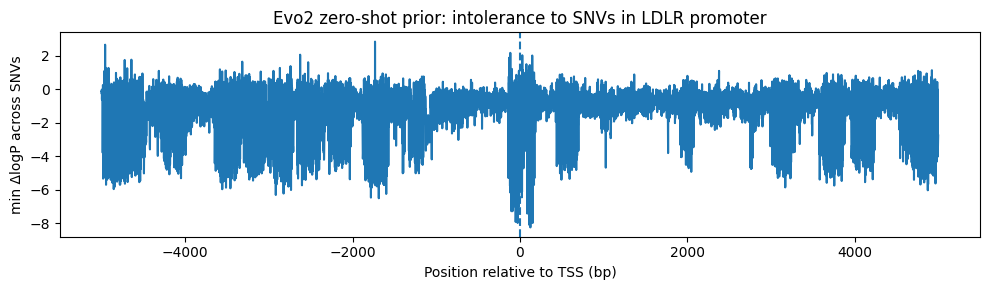

In [109]:
plt.figure(figsize=(10,3))
plt.axvline(0, linestyle="--")  # TSS
plt.plot(x, y)
plt.xlabel("Position relative to TSS (bp)")
plt.ylabel("min ΔlogP across SNVs")
plt.title("Evo2 zero-shot prior: intolerance to SNVs in LDLR promoter")
plt.tight_layout()
plt.show()